In [39]:
import json
import os

# JSON 파일들이 저장된 최상위 폴더 경로
json_folder_path = 'D:/car/095.상용 자율주행차 주간 자동차 전용도로 데이터/01-1.정식개방데이터/Training/02.라벨링데이터/TL'

# 선택할 범위 설정 (예: 폴더 목록 중 일부만 선택)
start_index = 0   # 시작 인덱스 (0부터 시작)
end_index = 656     # 끝 인덱스 (지정된 인덱스 직전까지 포함)

# 클래스 목록을 저장할 집합 (중복을 제거하기 위해 사용)
class_names = set()

# 최상위 폴더 내의 하위 폴더 목록 가져오기
subfolders = [f for f in os.listdir(json_folder_path) if os.path.isdir(os.path.join(json_folder_path, f))]

# 폴더 목록을 정렬한 후, 지정된 범위 내의 폴더들만 선택
subfolders.sort()  # 폴더명을 기준으로 정렬
selected_subfolders = subfolders[start_index:end_index]

# 선택된 폴더 목록 출력
print(f"Selected folders from index {start_index} to {end_index}:")
for folder in selected_subfolders:
    pass
    #print(f"- {folder}")

# 선택된 폴더들에 대해 JSON 파일 처리
for folder in selected_subfolders:
    folder_path = os.path.join(json_folder_path, folder, 'sensor_raw_data', 'lidar')

    # 폴더 내의 JSON 파일 목록 가져오기
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    
    for json_file in json_files:
        json_file_path = os.path.join(folder_path, json_file)
        #print(f"Processing {json_file_path}...")  # 디버깅용 출력

        try:
            with open(json_file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            # 객체 리스트 추출
            objects = data.get('annotation', {}).get('objects', [])
            if not objects:
                pass
                #print(f"No objects found in {json_file_path}")

            # 각 객체에서 클래스 이름 추출
            for obj in objects:
                category = obj['object']['category']
                class_names.add(category)

        except json.JSONDecodeError as e:
            print(f"Error reading {json_file_path}: {e}")
        except KeyError as e:
            print(f"Key error in {json_file_path}: {e}")

# 클래스 목록 출력
if class_names:
    print("\nUnique classes found in the selected range of folders:")
    for idx, class_name in enumerate(sorted(class_names)):
        print(f"{idx}: {class_name}")
else:
    print("\nNo classes found in the selected range of folders.")


Selected folders from index 0 to 656:

Unique classes found in the selected range of folders:
0: car
1: person
2: trafficLight
3: trafficSign
4: twoWheeler


In [1]:
#원본 데이터에서 일부(정면 카메라 데이터셋)만 갖고옴
import os
import json
import shutil

# 원본 경로 (여러 폴더가 있는 최상위 경로)
src_images_root = 'D:/car/095.상용 자율주행차 주간 자동차 전용도로 데이터/01-1.정식개방데이터/Training/01.원천데이터/TS'
src_labels_root = 'D:/car/095.상용 자율주행차 주간 자동차 전용도로 데이터/01-1.정식개방데이터/Training/02.라벨링데이터/TL'

# 복사할 대상 경로
dst_images_root = 'C:/Users/SBA/car/images'
dst_labels_root = 'C:/Users/SBA/car/labels'

# 복사할 하위 폴더 경로 (각각의 하위 경로)
image_sub_path = 'sensor_raw_data/camera'
label_sub_path = 'sensor_raw_data/lidar'

# 클래스 이름을 ID로 변환하는 사전
class_name_to_id = {
    "car": 0,
    "person": 1,
    "trafficLight": 2,
    "trafficSign": 3,
    "twoWheeler": 4,
    "truck": 5  # 새롭게 추가된 클래스 예시
}

# 이미지 크기 설정 (예: 1920x1080)
image_width = 1920
image_height = 1080

def convert_to_yolo_format(box, image_width, image_height):
    # xmin, ymin, xmax, ymax를 YOLO 포맷으로 변환
    xmin = box.get('xmin', 0)
    ymin = box.get('ymin', 0)
    xmax = box.get('xmax', 0)
    ymax = box.get('ymax', 0)
    
    # 바운딩 박스의 중심 좌표와 너비, 높이 계산
    x_center = (xmin + xmax) / 2 / image_width
    y_center = (ymin + ymax) / 2 / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height
    
    return x_center, y_center, width, height

def process_json_to_yolo(json_file_path, txt_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 'annotation' 데이터에서 객체 정보 추출
    annotation = data.get('annotation', {})
    objects = annotation.get('objects', [])
    
    with open(txt_file_path, 'w') as txt_file:
        for obj in objects:
            obj_data = obj.get('object', {})
            category = obj_data.get('category')
            box = obj_data.get('box', {})
            
            # 클래스 ID 가져오기
            class_id = class_name_to_id.get(category)
            if class_id is None:
                #print(f"Unknown category {category} in {json_file_path}, skipping...")
                continue
            
            # 바운딩 박스 정보를 YOLO 포맷으로 변환
            x_center, y_center, width, height = convert_to_yolo_format(box, image_width, image_height)
            
            # YOLO 형식으로 텍스트 파일에 기록
            txt_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def copy_and_convert_files(src_images_root, src_labels_root, dst_images_root, dst_labels_root, image_sub_path, label_sub_path):
    for subfolder in os.listdir(src_images_root):
        image_folder_path = os.path.join(src_images_root, subfolder, image_sub_path)
        label_folder_path = os.path.join(src_labels_root, subfolder, label_sub_path)
        
        # 이미지 파일 복사
        if os.path.exists(image_folder_path) and os.path.isdir(image_folder_path):
            dst_image_folder = os.path.join(dst_images_root, subfolder)
            os.makedirs(dst_image_folder, exist_ok=True)
            
            for file_name in os.listdir(image_folder_path):
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    src_file_path = os.path.join(image_folder_path, file_name)
                    dst_file_path = os.path.join(dst_image_folder, file_name)
                    
                    if not os.path.exists(dst_file_path):
                        shutil.copy(src_file_path, dst_file_path)
                        #print(f"Copied image {file_name} to {dst_file_path}")

        # 라벨 파일 변환 및 저장
        if os.path.exists(label_folder_path) and os.path.isdir(label_folder_path):
            dst_label_folder = os.path.join(dst_labels_root, subfolder)
            os.makedirs(dst_label_folder, exist_ok=True)
            
            for file_name in os.listdir(label_folder_path):
                if file_name.endswith('.json'):
                    src_file_path = os.path.join(label_folder_path, file_name)
                    txt_file_name = os.path.splitext(file_name)[0] + '.txt'
                    dst_txt_file_path = os.path.join(dst_label_folder, txt_file_name)
                    
                    # JSON 파일을 읽어 YOLO 형식의 텍스트 파일로 변환
                    process_json_to_yolo(src_file_path, dst_txt_file_path)
                    #print(f"Converted {file_name} to {txt_file_name} and saved to {dst_txt_file_path}")

# 함수 실행
copy_and_convert_files(src_images_root, src_labels_root, dst_images_root, dst_labels_root, image_sub_path, label_sub_path)



KeyboardInterrupt: 

In [2]:
#import os

# 이미지와 라벨 파일이 저장된 경로
#images_root = 'C:/Users/SBA/car/images'
#labels_root = 'C:/Users/SBA/car/labels'

#def check_image_label_pairs(images_root, labels_root):
    # 이미지 폴더 탐색
    #for subfolder in os.listdir(images_root):
        #image_folder_path = os.path.join(images_root, subfolder)
        #label_folder_path = os.path.join(labels_root, subfolder)

        # 이미지 폴더와 라벨 폴더가 있는지 확인
        #if not os.path.exists(label_folder_path):
            #print(f"Label folder not found for {subfolder}")
            #continue

        # 이미지 파일 목록과 라벨 파일 목록 가져오기
        #image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        #label_files = [f for f in os.listdir(label_folder_path) if f.endswith('.txt')]

        # 이미지 파일 이름에서 확장자를 제거한 목록 생성
        #image_file_names = set(os.path.splitext(f)[0] for f in image_files)
        #label_file_names = set(os.path.splitext(f)[0] for f in label_files)

        # 라벨 파일이 없는 이미지 찾기
        #images_without_labels = image_file_names - label_file_names
        #labels_without_images = label_file_names - image_file_names

        # 결과 출력
        #if images_without_labels:
            #print(f"Images without corresponding labels in {subfolder}:")
            #for image_name in images_without_labels:
                #print(f"  {image_name}.jpg")

        #if labels_without_images:
            #print(f"Labels without corresponding images in {subfolder}:")
            #for label_name in labels_without_images:
                #print(f"  {label_name}.txt")

        #if not images_without_labels and not labels_without_images:
            #print(f"All images have corresponding labels in {subfolder}")

# 함수 실행
#check_image_label_pairs(images_root, labels_root)


In [4]:
#이미지 라벨링 서로 대응되는지 확인이후 일치 하지 않는 것은 삭제
import os

# 이미지와 라벨 파일이 저장된 경로
images_root = 'C:/Users/SBA/car/images'
labels_root = 'C:/Users/SBA/car/labels'

def check_and_cleanup_image_label_pairs(images_root, labels_root):
    # 이미지 폴더 탐색
    for subfolder in os.listdir(images_root):
        image_folder_path = os.path.join(images_root, subfolder)
        label_folder_path = os.path.join(labels_root, subfolder)

        # 이미지 폴더와 라벨 폴더가 있는지 확인
        if not os.path.exists(label_folder_path):
            print(f"Label folder not found for {subfolder}")
            continue

        # 이미지 파일 목록과 라벨 파일 목록 가져오기
        image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        label_files = [f for f in os.listdir(label_folder_path) if f.endswith('.txt')]

        # 이미지 파일 이름에서 확장자를 제거한 목록 생성
        image_file_names = set(os.path.splitext(f)[0] for f in image_files)
        label_file_names = set(os.path.splitext(f)[0] for f in label_files)

        # 라벨 파일이 없는 이미지 찾기
        images_without_labels = image_file_names - label_file_names
        labels_without_images = label_file_names - image_file_names

        # 결과 출력 및 정리
        if images_without_labels:
            print(f"Images without corresponding labels in {subfolder}:")
            for image_name in images_without_labels:
                
                print(f"  {image_name}.jpg")

        if labels_without_images:
            print(f"Labels without corresponding images in {subfolder}:")
            for label_name in labels_without_images:
                label_file_path = os.path.join(label_folder_path, label_name + '.txt')
                print(f"  Deleting {label_file_path} (no corresponding image)")
                os.remove(label_file_path)

        if not images_without_labels and not labels_without_images:
            print(f"All images have corresponding labels in {subfolder}")
            
# 함수 실행
check_and_cleanup_image_label_pairs(images_root, labels_root)


All images have corresponding labels in 16_105517_220617
All images have corresponding labels in 16_105557_220617
All images have corresponding labels in 16_105617_220617
All images have corresponding labels in 16_105637_220617
All images have corresponding labels in 16_105657_220617
All images have corresponding labels in 16_105717_220617
All images have corresponding labels in 16_105837_220617
All images have corresponding labels in 16_105857_220617
All images have corresponding labels in 16_105917_220617
All images have corresponding labels in 16_105937_220617
All images have corresponding labels in 16_105957_220617
All images have corresponding labels in 16_110017_220617
All images have corresponding labels in 16_110037_220617
All images have corresponding labels in 16_110137_220617
All images have corresponding labels in 16_110157_220617
All images have corresponding labels in 16_110237_220617
All images have corresponding labels in 16_110337_220617
All images have corresponding l

In [5]:
#각 폴더의 이미지와 txt갯수 확인
import os

# 이미지와 라벨 파일이 저장된 경로
images_root = 'C:/Users/SBA/car/images'
labels_root = 'C:/Users/SBA/car/labels'

def count_files_in_folders(images_root, labels_root):
    # 결과 저장을 위한 딕셔너리
    folder_counts = {}

    # 이미지 폴더 탐색
    for subfolder in os.listdir(images_root):
        image_folder_path = os.path.join(images_root, subfolder)
        label_folder_path = os.path.join(labels_root, subfolder)
        
        # 이미지와 라벨 파일 수 초기화
        image_count = 0
        label_count = 0

        # 이미지 파일 개수 계산
        if os.path.exists(image_folder_path) and os.path.isdir(image_folder_path):
            image_count = len([f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])

        # 라벨 파일 개수 계산
        if os.path.exists(label_folder_path) and os.path.isdir(label_folder_path):
            label_count = len([f for f in os.listdir(label_folder_path) if f.endswith('.txt')])

        # 결과 저장
        folder_counts[subfolder] = {
            "image_count": image_count,
            "label_count": label_count
        }
    
    # 결과 출력
    for folder, counts in folder_counts.items():
        print(f"Folder: {folder}")
        print(f"  Images: {counts['image_count']}")
        print(f"  Labels: {counts['label_count']}")
        print("-" * 30)
        
# 함수 실행
count_files_in_folders(images_root, labels_root)


Folder: 16_105517_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105557_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105617_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105637_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105657_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105717_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105837_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105857_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105917_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105937_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_105957_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_110017_220617
  Images: 40
  Labels: 40
------------------------------
Folder: 16_11003

Processing 24_154622_220929_19.jpg with label 24_154622_220929_19.txt


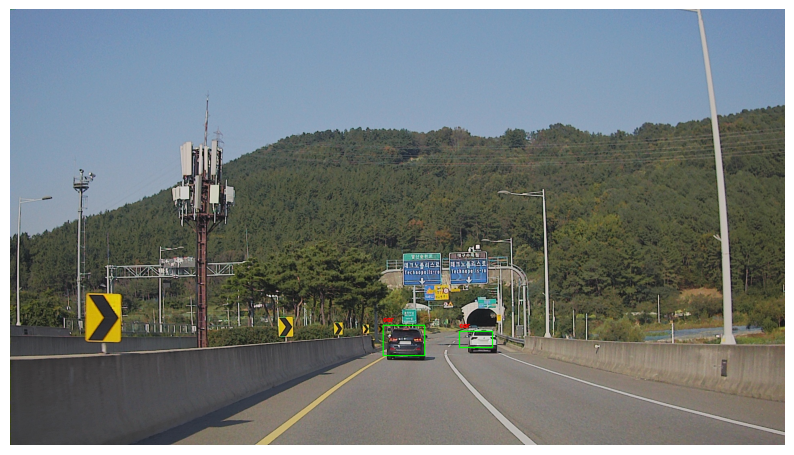

Processing 24_154622_220929_16.jpg with label 24_154622_220929_16.txt


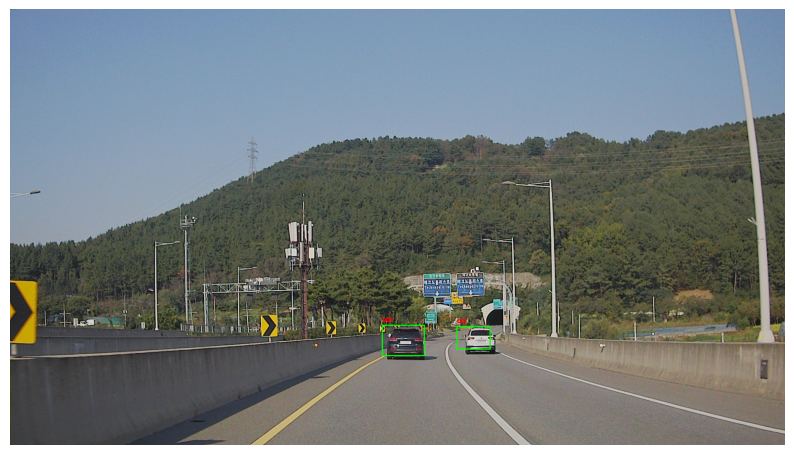

Processing 24_154622_220929_20.jpg with label 24_154622_220929_20.txt


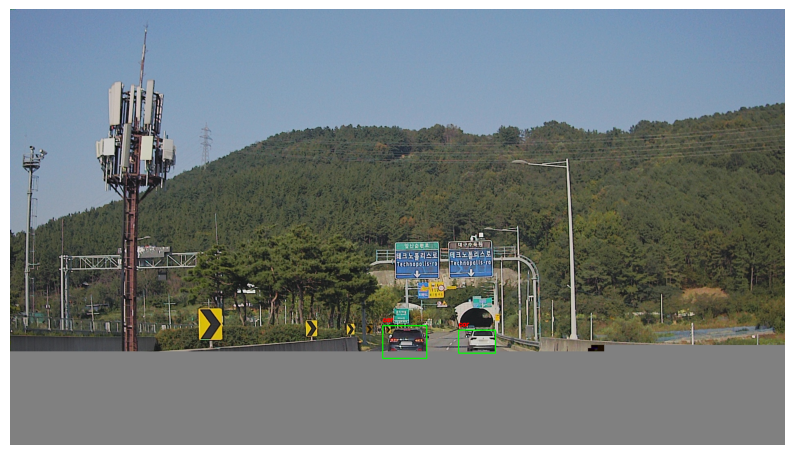

Processing 24_154622_220929_09.jpg with label 24_154622_220929_09.txt


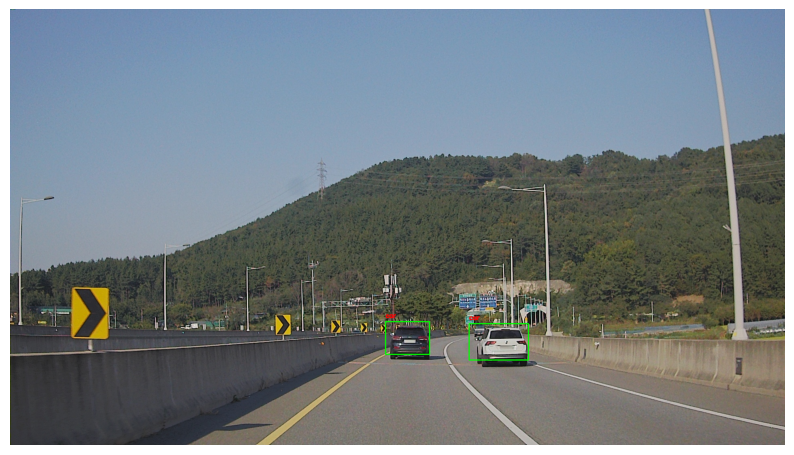

Processing 24_154622_220929_02.jpg with label 24_154622_220929_02.txt


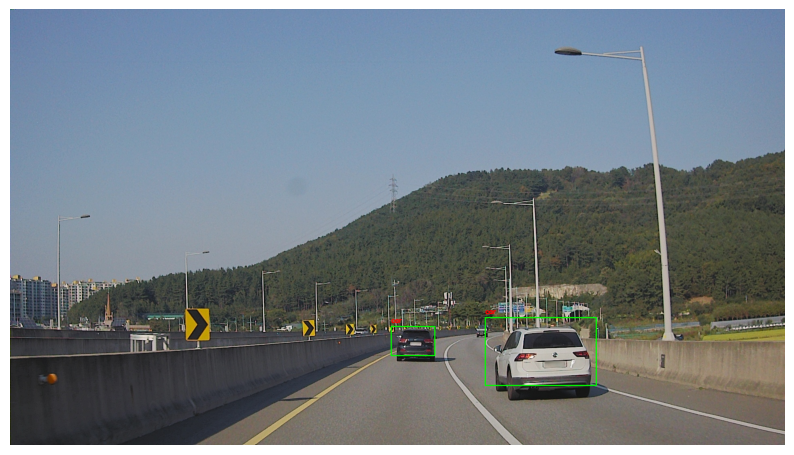

Processing 24_154622_220929_05.jpg with label 24_154622_220929_05.txt


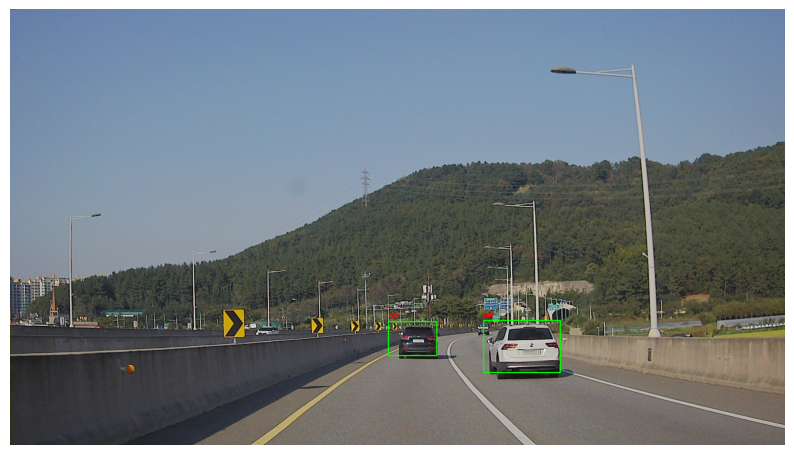

Processing 24_154622_220929_33.jpg with label 24_154622_220929_33.txt


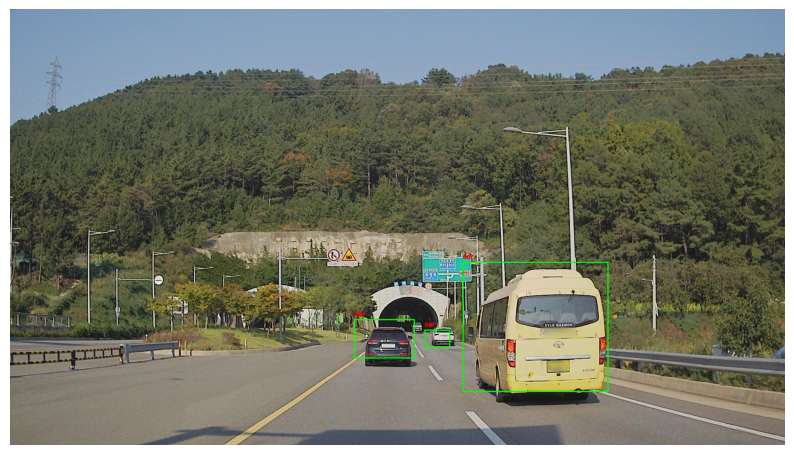

Processing 24_154622_220929_26.jpg with label 24_154622_220929_26.txt


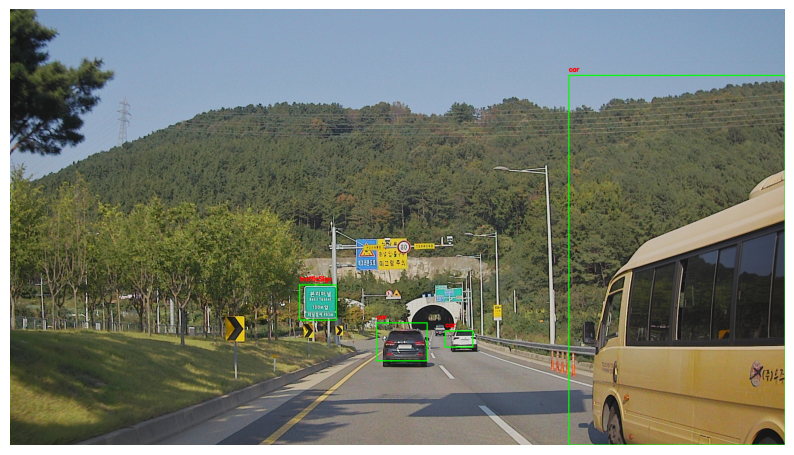

Processing 24_154622_220929_13.jpg with label 24_154622_220929_13.txt


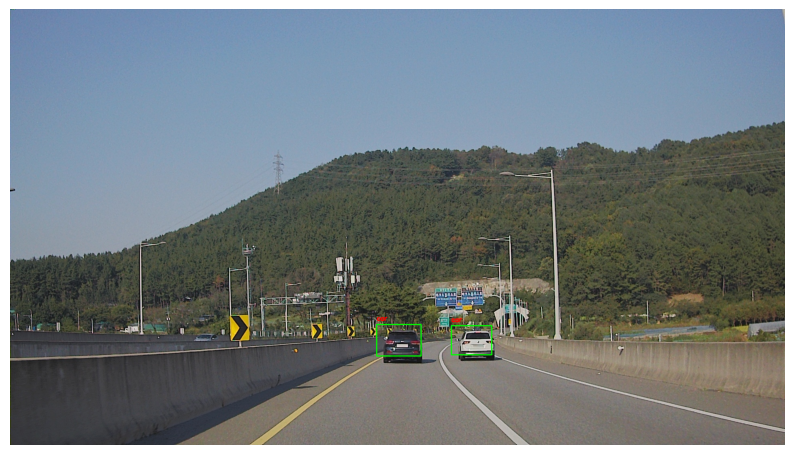

Processing 24_154622_220929_01.jpg with label 24_154622_220929_01.txt


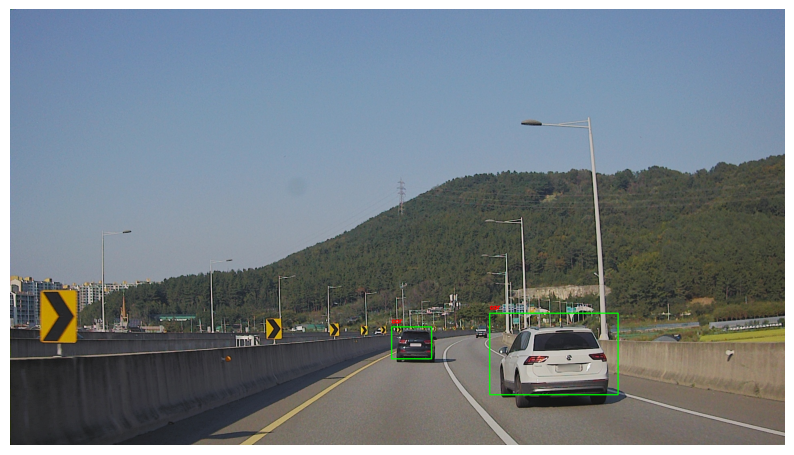

In [5]:
#박스 한번 확인
import os
import cv2
import random
import matplotlib.pyplot as plt

# 클래스 ID를 실제 클래스 이름으로 변환하는 사전
id_to_class_name = {
    0: "car",
    1: "person",
    2: "trafficLight",
    3: "trafficSign",
    4: "twoWheeler"
}

# 이미지 파일들이 저장된 경로와 라벨 파일들이 저장된 경로
images_dir = 'C:/Users/SBA/car/images/24_154622_220929'
labels_dir = 'C:/Users/SBA/car/labels/24_154622_220929'

# 이미지 크기 (예시로 1920x1080을 사용합니다. 이미지마다 다를 경우 개별 처리 필요)
image_width = 1920
image_height = 1080

def draw_boxes_from_yolo_labels(image_path, label_path):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    
    # OpenCV는 BGR 형식으로 이미지를 읽으므로, RGB 형식으로 변환
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # YOLO 라벨 파일 읽기
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # 각 라벨을 읽어와 이미지에 박스를 그리기
    for line in lines:
        # 라벨 파일의 각 라인: <class_id> <x_center> <y_center> <width> <height>
        class_id, x_center, y_center, width, height = map(float, line.split())
        class_id = int(class_id)
        class_name = id_to_class_name.get(class_id, "unknown")

        # YOLO 형식 좌표를 이미지 좌표로 변환
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height

        # 박스의 좌상단(xmin, ymin)과 우하단(xmax, ymax) 좌표 계산
        xmin = int(x_center - width / 2)
        ymin = int(y_center - height / 2)
        xmax = int(x_center + width / 2)
        ymax = int(y_center + height / 2)

        # 박스 그리기
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # 라벨 텍스트 추가
        cv2.putText(image, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # 이미지 Jupyter 노트북에서 표시하기
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 이미지와 라벨 파일을 처리하는 함수
def process_random_images(images_dir, labels_dir, num_samples=10):
    # 이미지 파일 목록 가져오기
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # 이미지 파일 중에서 랜덤으로 num_samples 개 선택
    random_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    for image_file in random_images:
        # 이미지 파일 경로
        image_path = os.path.join(images_dir, image_file)
        # 해당 이미지의 라벨 파일 경로 (확장자를 .txt로 변경)
        label_file_name = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file_name)
        
        # 라벨 파일이 존재할 경우에만 처리
        if os.path.exists(label_path):
            print(f"Processing {image_file} with label {label_file_name}")
            draw_boxes_from_yolo_labels(image_path, label_path)
        else:
            print(f"Label file not found for {image_file}, skipping...")

# 랜덤으로 10개의 이미지와 라벨 파일 처리
process_random_images(images_dir, labels_dir, num_samples=10)



In [6]:
#train,valid,test로 데이터 분리
import os
import shutil
import random

# 원본 이미지와 라벨 파일 경로
images_root = 'C:/Users/SBA/car/images'
labels_root = 'C:/Users/SBA/car/labels'

# 데이터셋 저장 경로
dataset_root = 'C:/Users/SBA/car/dataset'
train_dir = os.path.join(dataset_root, 'train')
valid_dir = os.path.join(dataset_root, 'valid')
test_dir = os.path.join(dataset_root, 'test')

# 이미지와 라벨을 저장할 폴더 생성 함수
def create_dirs(base_dir):
    image_dir = os.path.join(base_dir, 'images')
    label_dir = os.path.join(base_dir, 'labels')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    return image_dir, label_dir

# 데이터셋 폴더 생성
train_image_dir, train_label_dir = create_dirs(train_dir)
valid_image_dir, valid_label_dir = create_dirs(valid_dir)
test_image_dir, test_label_dir = create_dirs(test_dir)

# 각 폴더에서 뽑을 이미지 수
samples_per_folder = 40
samples_last_folder = 16  

def copy_to_dataset(selected_images, images_root, labels_root, image_destination_dir, label_destination_dir):
    """
    선택된 이미지와 해당하는 라벨 파일을 각각 image_destination_dir와 label_destination_dir에 복사하는 함수
    """
    for image_name in selected_images:
        # 이미지 파일 경로
        image_path = os.path.join(images_root, image_name + '.jpg')
        label_path = os.path.join(labels_root, image_name + '.txt')

        # 이미지와 라벨 파일 복사 (이미 존재하는 경우 건너뜀)
        dest_image_path = os.path.join(image_destination_dir, os.path.basename(image_path))
        dest_label_path = os.path.join(label_destination_dir, os.path.basename(label_path))

        if os.path.exists(image_path) and not os.path.exists(dest_image_path):
            shutil.copy(image_path, dest_image_path)
        if os.path.exists(label_path) and not os.path.exists(dest_label_path):
            shutil.copy(label_path, dest_label_path)

def create_dataset(images_root, labels_root, train_image_dir, train_label_dir, valid_image_dir, valid_label_dir, test_image_dir, test_label_dir, samples_per_folder, samples_last_folder):
    all_selected_images = set()  # 중복을 방지하기 위해 set 사용

    # 각 폴더에서 이미지 선택
    for subfolder in os.listdir(images_root):
        image_folder_path = os.path.join(images_root, subfolder)
        label_folder_path = os.path.join(labels_root, subfolder)

        # 이미지 파일 목록 가져오기 (확장자 제거한 파일명만 사용)
        image_files = [os.path.splitext(f)[0] for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        selected_images = set()
        # 샘플링할 이미지 수 결정
        target_sample_count = samples_last_folder if subfolder == sorted(os.listdir(images_root))[-1] else samples_per_folder

        # 남아 있는 이미지 수가 충분하지 않은 경우
        if len(image_files) < target_sample_count:
            print(f"Not enough images in {subfolder}. Only {len(image_files)} available.")
            target_sample_count = len(image_files)  # 가능한 이미지 수만큼 샘플링

        # 계속해서 필요한 이미지 수만큼 뽑기
        while len(selected_images) < target_sample_count:
            # 남은 수만큼 추가로 랜덤 샘플링
            remaining_count = target_sample_count - len(selected_images)
            new_samples = random.sample(image_files, min(remaining_count, len(image_files)))
            selected_images.update(new_samples)

        # 선택된 이미지를 저장 (중복 방지를 위해 전체 선택된 이미지 집합에 추가)
        all_selected_images.update([(subfolder, image) for image in selected_images])

    # 데이터셋 분할 (80% train, 10% valid, 10% test)
    all_selected_images = list(all_selected_images)
    random.shuffle(all_selected_images)
    num_total = len(all_selected_images)
    num_train = int(num_total * 0.8)
    num_valid = int(num_total * 0.1)
    
    train_images = all_selected_images[:num_train]
    valid_images = all_selected_images[num_train:num_train + num_valid]
    test_images = all_selected_images[num_train + num_valid:]

    # 선택된 이미지와 라벨 파일을 각 데이터셋 폴더로 복사
    for subfolder, image_name in train_images:
        copy_to_dataset([image_name], os.path.join(images_root, subfolder), os.path.join(labels_root, subfolder), train_image_dir, train_label_dir)
    for subfolder, image_name in valid_images:
        copy_to_dataset([image_name], os.path.join(images_root, subfolder), os.path.join(labels_root, subfolder), valid_image_dir, valid_label_dir)
    for subfolder, image_name in test_images:
        copy_to_dataset([image_name], os.path.join(images_root, subfolder), os.path.join(labels_root, subfolder), test_image_dir, test_label_dir)

    # 결과 출력
    print(f"Total images selected: {num_total}")
    print(f"Train images: {len(train_images)}")
    print(f"Valid images: {len(valid_images)}")
    print(f"Test images: {len(test_images)}")

# 시드값 고정 (결과 재현성을 위해)
random.seed(42)

# 함수 실행
create_dataset(images_root, labels_root, train_image_dir, train_label_dir, valid_image_dir, valid_label_dir, test_image_dir, test_label_dir, samples_per_folder, samples_last_folder)



Total images selected: 26216
Train images: 20972
Valid images: 2621
Test images: 2623


In [ ]:
#위에것을 실행했으면 아래것은 실행하면 안됩니다

In [ ]:
#위에것을 실행했으면 아래것은 실행하면 안됩니다

In [ ]:
#위에것을 실행했으면 아래것은 실행하면 안됩니다

In [ ]:
#전체
# import os
# import shutil
# import random

# # 원본 이미지와 라벨 파일 경로
# images_root = 'C:/Users/SBA/car/images'
# labels_root = 'C:/Users/SBA/car/labels'

# # 데이터셋 저장 경로
# dataset_root = 'C:/Users/SBA/car/dataset'
# train_dir = os.path.join(dataset_root, 'train')
# valid_dir = os.path.join(dataset_root, 'valid')
# test_dir = os.path.join(dataset_root, 'test')

# # 이미지와 라벨을 저장할 폴더 생성 함수
# def create_dirs(base_dir):
#     image_dir = os.path.join(base_dir, 'images')
#     label_dir = os.path.join(base_dir, 'labels')
#     os.makedirs(image_dir, exist_ok=True)
#     os.makedirs(label_dir, exist_ok=True)
#     return image_dir, label_dir

# # 데이터셋 폴더 생성
# train_image_dir, train_label_dir = create_dirs(train_dir)
# valid_image_dir, valid_label_dir = create_dirs(valid_dir)
# test_image_dir, test_label_dir = create_dirs(test_dir)

# def copy_to_dataset(selected_images, images_root, labels_root, image_destination_dir, label_destination_dir):
#     """
#     선택된 이미지와 해당하는 라벨 파일을 각각 image_destination_dir와 label_destination_dir에 복사하는 함수
#     """
#     for image_name in selected_images:
#         # 이미지 파일 경로
#         image_path = os.path.join(images_root, image_name + '.jpg')
#         label_path = os.path.join(labels_root, image_name + '.txt')

#         # 이미지와 라벨 파일 복사 (이미 존재하는 경우 건너뜀)
#         dest_image_path = os.path.join(image_destination_dir, os.path.basename(image_path))
#         dest_label_path = os.path.join(label_destination_dir, os.path.basename(label_path))

#         if os.path.exists(image_path) and not os.path.exists(dest_image_path):
#             shutil.copy(image_path, dest_image_path)
#         if os.path.exists(label_path) and not os.path.exists(dest_label_path):
#             shutil.copy(label_path, dest_label_path)

# def create_dataset(images_root, labels_root, train_image_dir, train_label_dir, valid_image_dir, valid_label_dir, test_image_dir, test_label_dir):
#     all_selected_images = set()  # 중복을 방지하기 위해 set 사용

#     # 각 폴더에서 이미지 선택
#     for subfolder in os.listdir(images_root):
#         image_folder_path = os.path.join(images_root, subfolder)
#         label_folder_path = os.path.join(labels_root, subfolder)

#         # 이미지 파일 목록 가져오기 (확장자 제거한 파일명만 사용)
#         image_files = [os.path.splitext(f)[0] for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

#         # 선택된 이미지를 저장 (중복 방지를 위해 전체 선택된 이미지 집합에 추가)
#         all_selected_images.update([(subfolder, image) for image in image_files])

#     # 데이터셋 분할 (80% train, 10% valid, 10% test)
#     all_selected_images = list(all_selected_images)
#     random.shuffle(all_selected_images)
#     num_total = len(all_selected_images)
#     num_train = int(num_total * 0.8)
#     num_valid = int(num_total * 0.1)
    
#     train_images = all_selected_images[:num_train]
#     valid_images = all_selected_images[num_train:num_train + num_valid]
#     test_images = all_selected_images[num_train + num_valid:]

#     # 선택된 이미지와 라벨 파일을 각 데이터셋 폴더로 복사
#     for subfolder, image_name in train_images:
#         copy_to_dataset([image_name], os.path.join(images_root, subfolder), os.path.join(labels_root, subfolder), train_image_dir, train_label_dir)
#     for subfolder, image_name in valid_images:
#         copy_to_dataset([image_name], os.path.join(images_root, subfolder), os.path.join(labels_root, subfolder), valid_image_dir, valid_label_dir)
#     for subfolder, image_name in test_images:
#         copy_to_dataset([image_name], os.path.join(images_root, subfolder), os.path.join(labels_root, subfolder), test_image_dir, test_label_dir)

#     # 결과 출력
#     print(f"Total images selected: {num_total}")
#     print(f"Train images: {len(train_images)}")
#     print(f"Valid images: {len(valid_images)}")
#     print(f"Test images: {len(test_images)}")

# # 시드값 고정 (결과 재현성을 위해)
# random.seed(42)

# # 함수 실행
# create_dataset(images_root, labels_root, train_image_dir, train_label_dir, valid_image_dir, valid_label_dir, test_image_dir, test_label_dir)


In [6]:
#import os

# 데이터셋 경로 설정
#dataset_root = 'C:/Users/SBA/car/dataset'
#train_dir = os.path.join(dataset_root, 'train')
#valid_dir = os.path.join(dataset_root, 'valid')
#test_dir = os.path.join(dataset_root, 'test')

# 클래스 목록 정의
#class_names = ['car', 'person', 'trafficLight', 'trafficSign', 'twoWheeler']  # 클래스 이름들

# data.yaml 파일 경로
#data_yaml_path = os.path.join(dataset_root, 'data.yaml')

# data.yaml 파일 생성 함수
#def create_data_yaml(train_dir, valid_dir, test_dir, class_names, yaml_path):
    #data = f"""
#train: {train_dir.replace(os.sep, '/')}
#val: {valid_dir.replace(os.sep, '/')}
#test: {test_dir.replace(os.sep, '/')}

#nc: {len(class_names)}  # 클래스 수
#names: {class_names}
"""
    # YAML 파일 저장
    with open(yaml_path, 'w') as f:
        f.write(data.strip())
    print(f"data.yaml 파일이 {yaml_path}에 생성되었습니다.")

# 함수 실행
create_data_yaml(train_dir, valid_dir, test_dir, class_names, data_yaml_path)
"""


'\n    # YAML 파일 저장\n    with open(yaml_path, \'w\') as f:\n        f.write(data.strip())\n    print(f"data.yaml 파일이 {yaml_path}에 생성되었습니다.")\n\n# 함수 실행\ncreate_data_yaml(train_dir, valid_dir, test_dir, class_names, data_yaml_path)\n'

In [15]:
os.getcwd()

'C:\\Users\\SBA'

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")  # 사전 학습된 YOLO11n 모델을 불러옴

# Train the model
results = model.train(
    data="C:/Users/SBA/car/dataset/data.yaml",  # 데이터 설정 파일 경로
    epochs=200,
    imgsz=640,
    batch=16,
    amp=False,
    project='C:/Users/SBA/car/runs',  # 결과를 저장할 기본 디렉토리 경로
    name='my_custom_train'  # 저장되는 폴더 이름 (기본 디렉토리 내에 생성됨)
)


New https://pypi.org/project/ultralytics/8.3.15 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.6  Python-3.12.7 torch-2.4.1 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:/Users/SBA/car/dataset/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=C:/Users/SBA/car/runs, name=my_custom_train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning C:\Users\SBA\car\dataset\train\labels... 20972 images, 1570 backgrounds, 0 corrupt: 100%|██████████| 20

train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105517_220617_05.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105517_220617_08.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105517_220617_09.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105517_220617_23.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105517_220617_25.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105517_220617_26.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_105617_220617_28.jpg: 4 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_112421_220609_34.jpg: 2 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train\images\16_112721_220609_35.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\SBA\car\dataset\train

train: New cache created: C:\Users\SBA\car\dataset\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\SBA\car\dataset\valid\labels... 2621 images, 199 backgrounds, 0 corrupt: 100%|██████████| 2621/2

val: WARNING  C:\Users\SBA\car\dataset\valid\images\16_142441_220613_20.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\SBA\car\dataset\valid\images\24_152104_220929_05.jpg: 3 duplicate labels removed


val: New cache created: C:\Users\SBA\car\dataset\valid\labels.cache
Plotting labels to C:\Users\SBA\car\runs\my_custom_train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\SBA\car\runs\my_custom_train4
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.49G      1.612      1.787      1.295         40        640: 100%|██████████| 1311/1311 [07:09<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:30


                   all       2621       6724      0.853      0.221      0.221      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.54G      1.495      1.201      1.206         86        640: 100%|██████████| 1311/1311 [06:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26


                   all       2621       6724      0.865      0.217      0.227      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.53G      1.502      1.064      1.226         54        640: 100%|██████████| 1311/1311 [06:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26


                   all       2621       6724      0.653       0.19      0.207      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.54G      1.484     0.9815       1.23         69        640: 100%|██████████| 1311/1311 [06:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26


                   all       2621       6724       0.27      0.219      0.233      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       4.5G      1.417     0.9082      1.202         50        640: 100%|██████████| 1311/1311 [06:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25


                   all       2621       6724      0.265      0.225      0.239      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.51G      1.382     0.8765      1.184         35        640: 100%|██████████| 1311/1311 [06:42<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.273      0.228      0.248      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.54G      1.341     0.8415      1.161         40        640: 100%|██████████| 1311/1311 [06:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.281      0.232      0.251      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200       4.5G      1.317     0.8219      1.149         53        640: 100%|██████████| 1311/1311 [06:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.286      0.241      0.257       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.53G      1.291     0.8024      1.135         63        640: 100%|██████████| 1311/1311 [06:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.285      0.243       0.26      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       4.5G      1.271      0.783      1.122         48        640: 100%|██████████| 1311/1311 [06:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.289      0.252      0.267       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.53G      1.253     0.7641      1.115         45        640: 100%|██████████| 1311/1311 [06:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.486       0.25      0.431       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.46G      1.237     0.7533      1.105         45        640: 100%|██████████| 1311/1311 [06:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.692      0.255      0.373      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.54G      1.225     0.7401      1.095         55        640: 100%|██████████| 1311/1311 [06:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.685      0.261      0.336      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       4.5G      1.208     0.7312      1.087         55        640: 100%|██████████| 1311/1311 [06:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.698      0.258      0.398      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.54G      1.205     0.7189      1.087         40        640: 100%|██████████| 1311/1311 [06:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.702      0.254      0.385      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200       4.5G      1.194     0.7117      1.083         78        640: 100%|██████████| 1311/1311 [06:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724        0.7      0.257      0.398      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.52G      1.181     0.7035      1.078         55        640: 100%|██████████| 1311/1311 [06:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.329       0.41      0.376      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.52G      1.177     0.6959      1.071         49        640: 100%|██████████| 1311/1311 [06:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724      0.371      0.434       0.42      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.53G      1.169     0.6907      1.068         76        640: 100%|██████████| 1311/1311 [06:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724       0.56      0.429       0.44      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.54G      1.162     0.6836      1.065         34        640: 100%|██████████| 1311/1311 [06:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724      0.629      0.465      0.498      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.54G       1.16     0.6757      1.063         41        640: 100%|██████████| 1311/1311 [06:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724      0.476      0.394      0.443      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       4.4G      1.151     0.6721       1.06         36        640: 100%|██████████| 1311/1311 [06:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.549      0.431       0.49      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.53G      1.144     0.6642      1.057         63        640: 100%|██████████| 1311/1311 [06:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724      0.596      0.427      0.486      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.53G      1.139      0.661      1.051         49        640: 100%|██████████| 1311/1311 [06:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724      0.569      0.482      0.514      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.53G       1.13     0.6522      1.049         64        640: 100%|██████████| 1311/1311 [06:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.552      0.463      0.512      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       4.5G       1.13      0.649      1.044         53        640: 100%|██████████| 1311/1311 [06:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:25

                   all       2621       6724      0.607      0.472      0.513       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.52G      1.126     0.6474      1.045         80        640: 100%|██████████| 1311/1311 [06:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.688      0.456      0.522      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       4.5G      1.122     0.6417      1.043         70        640: 100%|██████████| 1311/1311 [06:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.641      0.484      0.529       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.53G      1.115     0.6396      1.036         69        640: 100%|██████████| 1311/1311 [06:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.622      0.464       0.51      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.52G      1.113     0.6351      1.038         49        640: 100%|██████████| 1311/1311 [06:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.771      0.542      0.522      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.54G      1.106     0.6318      1.031         55        640: 100%|██████████| 1311/1311 [06:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.772      0.518      0.537      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       4.5G       1.11     0.6321      1.034         55        640: 100%|██████████| 1311/1311 [06:56<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:26

                   all       2621       6724      0.763      0.535      0.538      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200       4.4G      1.103     0.6229       1.03         58        640: 100%|██████████| 1311/1311 [07:00<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.784      0.529       0.55      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.52G      1.098     0.6252      1.026         71        640: 100%|██████████| 1311/1311 [07:02<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.835      0.471      0.539      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       4.5G      1.095     0.6208      1.027         60        640: 100%|██████████| 1311/1311 [06:59<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.741      0.547      0.536      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.46G      1.096     0.6169      1.028         46        640: 100%|██████████| 1311/1311 [07:01<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:27

                   all       2621       6724      0.772       0.54      0.546      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.34G      1.083     0.6084       1.02         78        640:  66%|██████▋   | 870/1311 [04:38<02:27, 

In [11]:
''''
model = YOLO("yolo11n.pt")  # load an official model
model = YOLO("path/to/best.pt")  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category
''''

Ultralytics 8.3.6  Python-3.12.7 torch-2.4.1 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


FileNotFoundError: '/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml' does not exist

In [8]:
from ultralytics import YOLO
import os
from datetime import datetime

# 경로 설정
runs_folder = "C:/Users/SBA/car/runs"

# 가장 최근에 생성된 폴더 찾기
train_folders = [f for f in os.listdir(runs_folder) if os.path.isdir(os.path.join(runs_folder, f))]
train_folders.sort(key=lambda x: os.path.getmtime(os.path.join(runs_folder, x)), reverse=True)
latest_train_folder = train_folders[0] if train_folders else None

# best.pt 경로 설정
if latest_train_folder:
    best_model_path = os.path.join(runs_folder, latest_train_folder, "weights", "best.pt")
    print(f"Using model from: {best_model_path}")
else:
    raise FileNotFoundError("No training folders found in the specified runs directory.")

# Load the trained model
model = YOLO(best_model_path)

# 테스트 이미지 폴더 경로 설정
test_image_folder = "C:/Users/SBA/car/dataset/test/images"

# 결과를 저장할 폴더 설정 (현재 날짜와 시간을 기준으로 폴더 이름 생성)
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = f"C:/Users/SBA/car/detect/test_results_{current_time}"
os.makedirs(output_folder, exist_ok=True)

# 예측 수행
results = model.predict(
    source=test_image_folder,  # 테스트 이미지 폴더
    save=True,                 # 결과 이미지 저장
    save_txt=True,             # 탐지 결과 텍스트로 저장
    save_conf=True,            # 탐지된 객체의 신뢰도 점수도 저장
    conf=0.25,                 # 탐지 신뢰도 임계값 설정
    project=output_folder,     # 결과 저장 폴더
    name="test_run"            # 저장될 결과 폴더 이름
)


Using model from: C:/Users/SBA/car/runs\my_custom_train2\weights\best.pt


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2623 C:\Users\SBA\car\dataset\test\images\16_105517_220617_03.jpg: 384x640 1 car, 1 trafficSign, 52.0ms
image 2/2623 C:\Users\SBA\car\dataset\test\images\16_105517_220617_07.jpg: 384x640 3 cars, 2 trafficSigns, 56.3ms
image 3/2623 C:\Users\SBA\car\dataset\test\images\16_105517_220617_10.jpg: 384x640 2 cars, 2 trafficSigns, 26.6ms
image 4/2623 C:\Users\SBA\car\dataset\test\im

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 6220800 bytes in function 'cv::OutOfMemoryError'


In [1]:
import os
import shutil

# 이미지가 저장된 폴더들
base_folder = r"C:\Users\SBA\car\detect"
folders = [
    #os.path.join(base_folder, "test_results_20241017_113100", "test_run"),
    os.path.join(base_folder, "test_results_20241017_132153", "test_run"),
    #os.path.join(base_folder, "test_results_20241017_182349", "test_run"),
    os.path.join(base_folder, "test_results_20241018_090414", "test_run")
    
   
    
]

# 결과를 저장할 기본 폴더 (공통된 이미지가 복사될 상위 폴더)
output_base_folder = r"C:\Users\SBA\car\detect\common_images2_4"
os.makedirs(output_base_folder, exist_ok=True)

# 각 폴더에서 이미지 파일 이름 수집 (폴더가 있는 경우에만)
file_sets = []
for folder in folders:
    if os.path.exists(folder):
        # 이미지 파일만 수집 (jpg, png 등 필요한 확장자만)
        file_sets.append(
            set(f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
        )
    else:
        print(f"경고: {folder} 경로가 존재하지 않습니다. 이 폴더는 건너뜁니다.")

# 모든 폴더에 공통으로 존재하는 파일 이름 찾기
if file_sets:
    common_files = set.intersection(*file_sets)
else:
    common_files = set()

# 공통 파일을 각각의 폴더로 복사하여 정리
for common_file in common_files:
    # 공통된 파일 이름을 기반으로 폴더 생성
    common_folder = os.path.join(output_base_folder, common_file.split('.')[0])  # 확장자 제거
    os.makedirs(common_folder, exist_ok=True)
    
    for folder in folders:
        src = os.path.join(folder, common_file)
        # 각 파일을 원본 폴더 이름을 포함하여 복사 (중복 방지)
        folder_name = os.path.basename(os.path.dirname(folder))  # 날짜 정보 포함된 폴더 이름 추출
        dst = os.path.join(common_folder, f"{folder_name}_{common_file}")
        
        if os.path.exists(src):
            try:
                shutil.copy(src, dst)
                print(f"Copied {common_file} from {folder} to {dst}")
            except PermissionError as e:
                print(f"PermissionError: {e}. 파일 {common_file}을 복사할 수 없습니다.")

print(f"공통된 이미지 파일 {len(common_files)}개의 각 경로에서 복사를 완료했습니다.")


Copied 24_142714_220630_21.jpg from C:\Users\SBA\car\detect\test_results_20241017_132153\test_run to C:\Users\SBA\car\detect\common_images2_4\24_142714_220630_21\test_results_20241017_132153_24_142714_220630_21.jpg
Copied 24_142714_220630_21.jpg from C:\Users\SBA\car\detect\test_results_20241018_090414\test_run to C:\Users\SBA\car\detect\common_images2_4\24_142714_220630_21\test_results_20241018_090414_24_142714_220630_21.jpg
Copied 16_172434_220929_10.jpg from C:\Users\SBA\car\detect\test_results_20241017_132153\test_run to C:\Users\SBA\car\detect\common_images2_4\16_172434_220929_10\test_results_20241017_132153_16_172434_220929_10.jpg
Copied 16_172434_220929_10.jpg from C:\Users\SBA\car\detect\test_results_20241018_090414\test_run to C:\Users\SBA\car\detect\common_images2_4\16_172434_220929_10\test_results_20241018_090414_16_172434_220929_10.jpg
Copied 24_084053_221104_22.jpg from C:\Users\SBA\car\detect\test_results_20241017_132153\test_run to C:\Users\SBA\car\detect\common_images2_